In [97]:
import holidays

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score

In [98]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)

In [99]:
### visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [100]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [101]:
df.info()
df_copy = df.copy()
# Encontramos valores nulos en las columnas 'dropoff_longitude' y 'dropoff_latitude'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [102]:
df.isnull().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

# Cantidad de Pasajeros
-------------

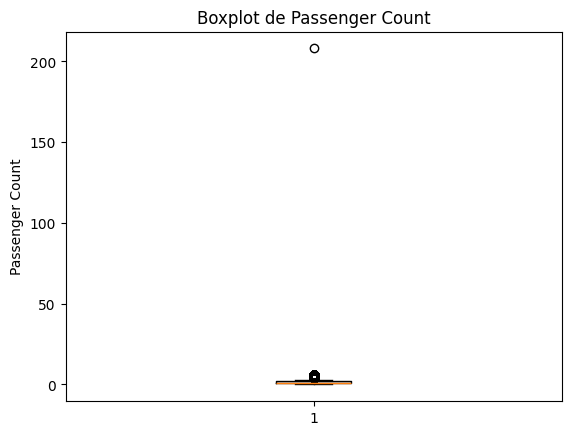

In [103]:
# Box plot de los datos de la variable Cantidad de Pasajeros
plt.boxplot(df['passenger_count'])
plt.title('Boxplot de Passenger Count')
plt.ylabel('Passenger Count')
plt.show()

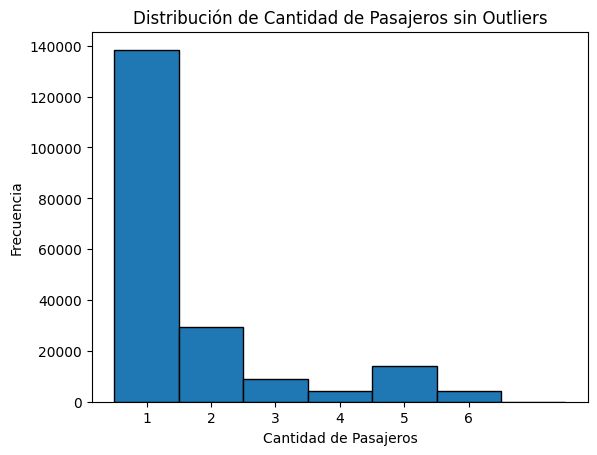

In [104]:
# Eliminamos registros con valores mayores a 6
df_copy = df_copy[df_copy['passenger_count'] <= 6]

# Visualizamos la distribucion de la variable 'passenger_count' sin outliers
plt.hist(df_copy['passenger_count'], bins=range(1, 9), edgecolor='black', align='left')
plt.title('Distribución de Cantidad de Pasajeros sin Outliers')
plt.xlabel('Cantidad de Pasajeros')
plt.ylabel('Frecuencia')
plt.xticks(range(1, 7))
plt.show()

/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_32354/3876717696.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




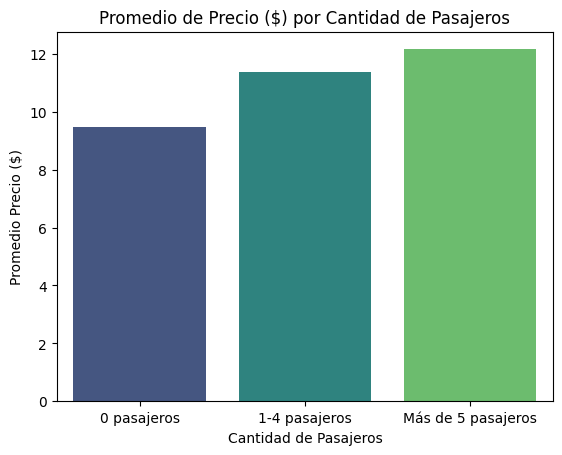

In [105]:
''' 
Calculamos y visualizamos el promedio de la variable 'fare_amount' para los diferentes servicios de Uber según cantidad de pasajeros.
- 0 pasajeros
- 1-4 pasajeros
- Más de 5 pasajeros
'''


prom56 = df_copy[df_copy['passenger_count'] > 5]['fare_amount'].mean()
prom0 = df_copy[df_copy['passenger_count'] == 0]['fare_amount'].mean()
prom14 = df_copy[(df_copy['passenger_count'] >= 1) & (df_copy['passenger_count'] <= 4)]['fare_amount'].mean()

promedios = pd.DataFrame({
    'Cantidad de Pasajeros': ['0 pasajeros', '1-4 pasajeros', 'Más de 5 pasajeros'],
    'Promedio Precio': [prom0, prom14, prom56]
})

sns.barplot(data=promedios, x='Cantidad de Pasajeros', y='Promedio Precio', palette='viridis')
plt.title('Promedio de Precio ($) por Cantidad de Pasajeros')
plt.ylabel('Promedio Precio ($)')
plt.xlabel('Cantidad de Pasajeros')
plt.show();


In [106]:
'''
Eliminamos los valores de la columna 'passenger_count' que sean mayores a 7  ya que es el máximo permitido en los vehiculos de la flota de Uber.

Luego creamos variables Dummies para los tipos de servicio de Uber:
- Uber Eats (0 pasajeros)
- Uber Normal (1 a 5 pasajeros)
- Uber XL (6 pasajeros o más)
'''


# Crear columnas booleanas
df_copy['uber_eats'] = (df_copy['passenger_count'] == 0).astype(int)
df_copy['uber_normal'] = ((df_copy['passenger_count'] >= 1) & (df_copy['passenger_count'] <= 5)).astype(int)
df_copy['uber_xl'] = (df_copy['passenger_count'] >= 6).astype(int)

# Fecha
--------------

In [107]:
'''
En la variable 'pickup_datetime' observamos que los valores se encuentran en rangos normales,
por lo que no realizamos ninguna modificacion
'''
df_copy['pickup_datetime'].describe()

count                      199999
unique                     196628
top       2009-02-12 12:46:00 UTC
freq                            4
Name: pickup_datetime, dtype: object

In [108]:
'''
Convertimos la columna 'pickup_datetime' a tipo datetime,
para luego poder dividir los datos en
- Año
- Mes
- Día
- Hora
- Día de la semana (0 = Lunes, 6 = Domingo)
- Viernes (0 = No, 1 = Si)
- Sábado (0 = No, 1 = Si)
- Domingo o Jueves (0 = No, 1 = Si)
'''

df_copy['pickup_datetime'] = pd.to_datetime(df_copy['pickup_datetime'])

df_copy["year"] = df_copy["pickup_datetime"].dt.year
df_copy["month"] = df_copy["pickup_datetime"].dt.month
df_copy["day"] = df_copy["pickup_datetime"].dt.day
df_copy["hour"] = df_copy["pickup_datetime"].dt.hour

df_copy["weekday"] = df_copy["pickup_datetime"].dt.weekday  # 0 = Lunes, 6 = Domingo
df_copy["viernes"] = (df_copy["weekday"] == 4).astype(int)  
df_copy["sabado"] = (df_copy["weekday"] == 5).astype(int)
df_copy["domingo_jueves"] = ((df_copy["weekday"] == 6) | (df_copy['weekday'] == 3)).astype(int)

In [109]:

# Crear un objeto con los feriados en EE.UU.
us_holidays = holidays.US()

''' 
Agregamos una columna con los dias feriados en EE.UU.
- 0 = No es feriado
- 1 = Es feriado
'''
df_copy['feriado'] = df_copy['pickup_datetime'].dt.date.apply(lambda x: 1 if x in us_holidays else 0)
df_copy['feriado'].value_counts()

feriado
0    195475
1      4524
Name: count, dtype: int64

## Visualización de las nuevas columnas creadas
-----

/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_32354/3943787133.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_32354/3943787133.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




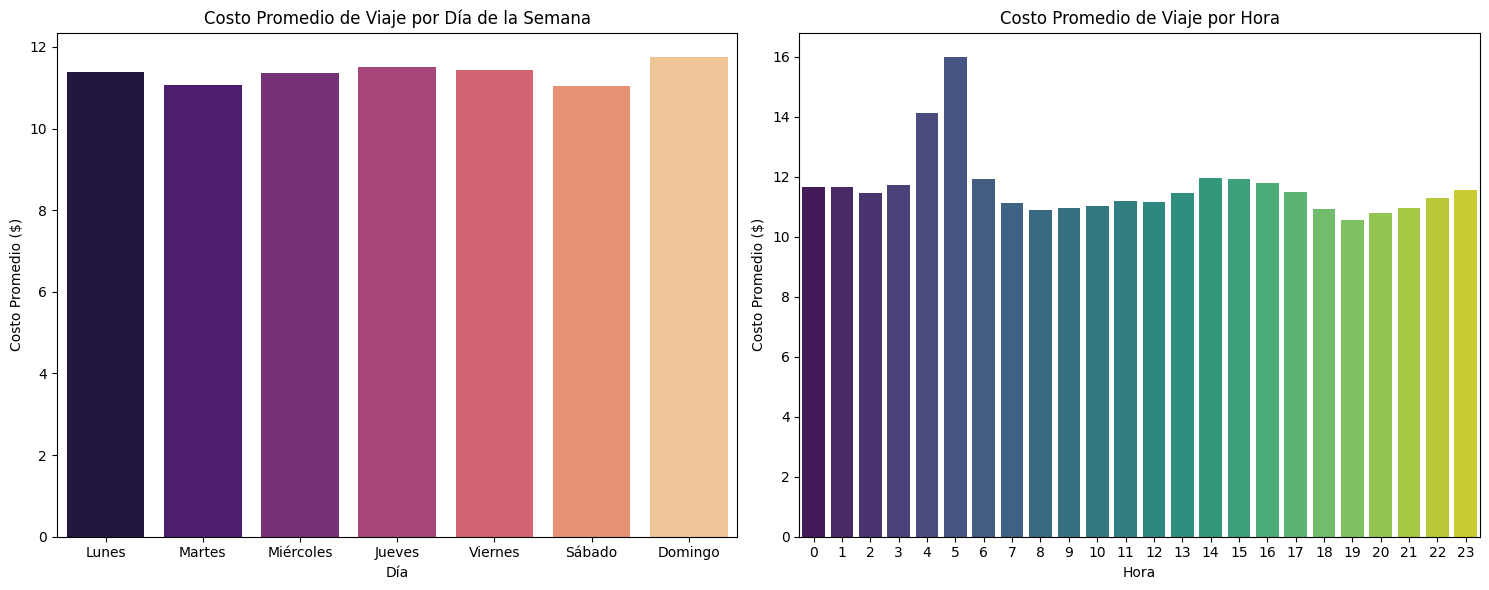

In [110]:
promedio_dia_semana = df_copy.groupby('weekday')['fare_amount'].mean().reset_index()

# Calculamos el costo promedio de viaje por hora
promedio_por_hora = df_copy.groupby('hour')['fare_amount'].mean().reset_index()
promedio_por_hora.columns = ['Hora', 'Costo Promedio']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico del costo promedio de viaje por día de la semana
sns.barplot(data=promedio_dia_semana, x='weekday', y='fare_amount', palette='magma', ax=axes[0])
axes[0].set_title('Costo Promedio de Viaje por Día de la Semana')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Costo Promedio ($)')
axes[0].set_xticks(range(0, 7))
axes[0].set_xticklabels(['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

# Gráfico del costo promedio de viaje por hora
sns.barplot(data=promedio_por_hora, x='Hora', y='Costo Promedio', palette='viridis', ax=axes[1])
axes[1].set_title('Costo Promedio de Viaje por Hora')
axes[1].set_xlabel('Hora')
axes[1].set_ylabel('Costo Promedio ($)')
axes[1].set_xticks(range(0, 24))

# Ajustar el espacio entre los subplots
plt.tight_layout()
plt.show();

# ¿Hora, año y mes debemos usar one-hot encoding?
----------
### Año (cuantitativo discreto)
Se puede usar directamente como una variable numérica en la regresión.
Ejemplo: 2023, 2024, 2025.
### Mes (categórico ordinal o numérico discreto)
Probar representandolo como numero
### Día de la semana (categórico nominal)
No tiene un valor numérico natural, por lo que debe codificarse como variables dummy (one-hot encoding).
Ejemplo:
lunes=1, martes=0, ..., domingo=0.
### Día del mes (cuantitativo discreto)
Se puede usar como un número directamente (1 al 31).
No es necesario hacer one-hot encoding.
### Hora
Probar como variable continua o agrupar segun franja horaria
df["franja_horaria"] = pd.cut(df["hora"], bins=[0, 6, 12, 18, 24], labels=["madrugada", "mañana", "tarde", "noche"])
df = pd.get_dummies(df, columns=["franja_horaria"])

----


/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_32354/2050568071.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/l1/5h810w6x4hz_8yc4sfqwjlkr0000gn/T/ipykernel_32354/2050568071.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




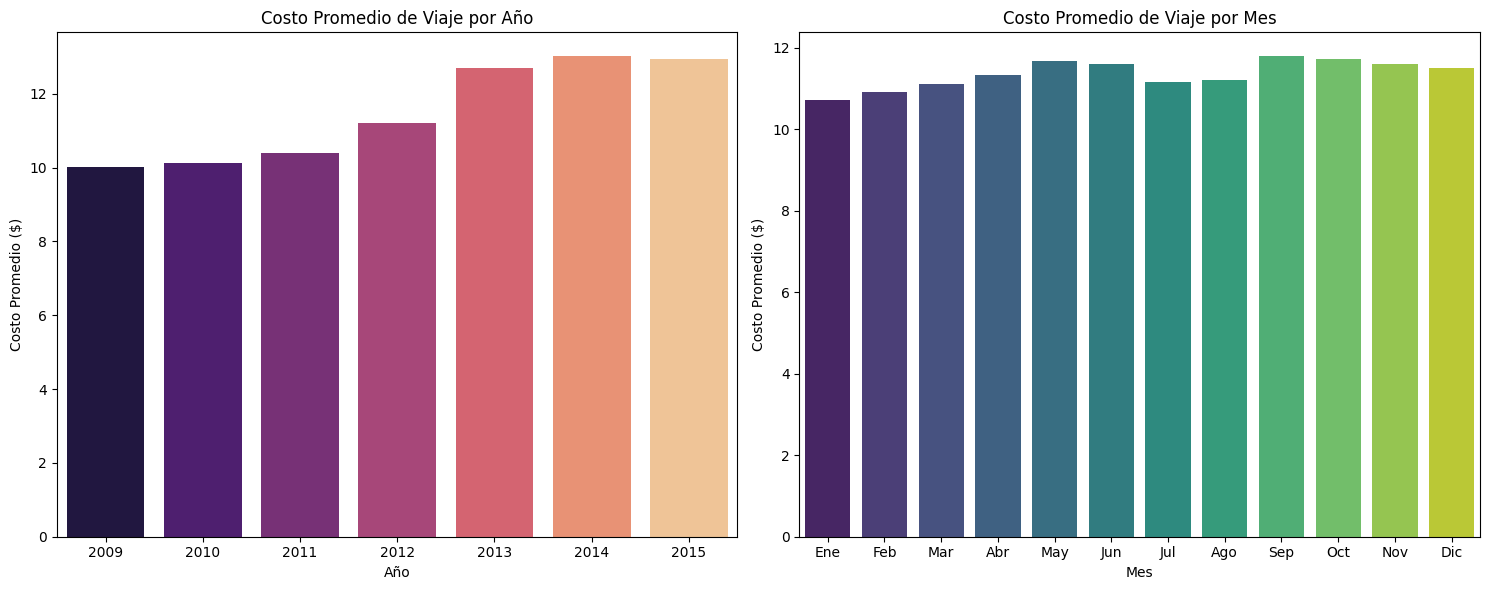

In [111]:
# Calculamos el costo promedio de viaje por mes
promedio_por_mes = df_copy.groupby('month')['fare_amount'].mean().reset_index()
promedio_por_mes.columns = ['Mes', 'Costo Promedio']

# Calculamos el costo promedio de viaje por año
promedio_por_anio = df_copy.groupby('year')['fare_amount'].mean().reset_index()
promedio_por_anio.columns = ['Año', 'Costo Promedio']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.barplot(data=promedio_por_anio, x='Año', y='Costo Promedio', palette='magma', ax=axes[0])
axes[0].set_title('Costo Promedio de Viaje por Año')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Costo Promedio ($)')

sns.barplot(data=promedio_por_mes, x='Mes', y='Costo Promedio', palette='viridis', ax=axes[1])
axes[1].set_title('Costo Promedio de Viaje por Mes')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('Costo Promedio ($)')
axes[1].set_xticks(range(0, 12))
axes[1].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.tight_layout()
plt.show();

# Variables de Posición Geográfica
-----------

In [112]:
'''
Eliminamos los viajes en donde la latitud de origen o destino sea menor a -55.95 o mayor a 70.75, 
ya que estaría fuera de los límites en los que Uber opera sus viajes
'''
df_copy = df_copy[(df_copy['pickup_latitude'] > -55.95) & (df_copy['pickup_latitude'] < 70.75)]
df_copy = df_copy[(df_copy['dropoff_latitude'] > -55.95) & (df_copy['dropoff_latitude'] < 70.75)]

In [113]:
'''
Eliminamos los datos de longitud de origen o destino mayores a 180 o menores a -180,
ya que no representan coordenadas reales
'''
df_copy = df_copy[(df_copy['pickup_longitude'] > -180) & (df_copy['dropoff_longitude'] > -180)]
df_copy = df_copy[(df_copy['pickup_longitude'] < 180) & (df_copy['dropoff_longitude'] < 180)]



### Deberiamos probar de crear una variable distancia

# Precio
---------------

In [114]:
'''
Observamos que en la columna fare_amount se registran valores negativos,
al ser una variable que permite valores negativos, eliminamos los registros con valores negativos
'''
df['fare_amount'].describe()

count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

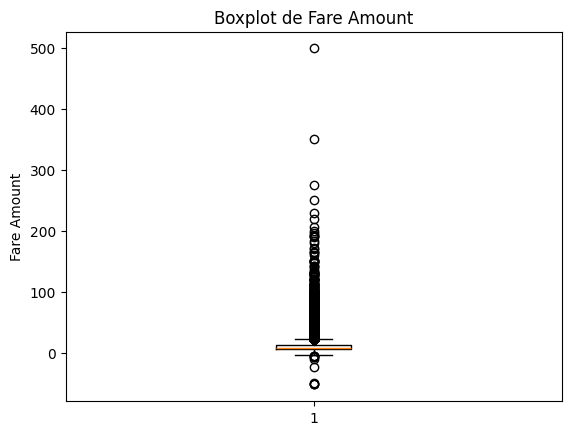

In [115]:
plt.boxplot(df_copy['fare_amount'])
plt.title('Boxplot de Fare Amount')
plt.ylabel('Fare Amount')
plt.show()


In [116]:
# Eliminamos los registros con valores negativos
df_copy = df_copy[df_copy['fare_amount'] >= 0]
# Eliminamos los registros con valores negativos
df_copy = df_copy[df_copy['fare_amount'] <= 300]

In [117]:
print(f'Cantidad de datos previos a la limpieza: {df.shape[0]}')
print(f'Cantidad de datos posteriores a la limpieza: {df_copy.shape[0]}')

Cantidad de datos previos a la limpieza: 200000
Cantidad de datos posteriores a la limpieza: 199865


In [118]:
# Matriz de correlación de las variables numéricas
'''
No vamos a sacar variables altamente correlacionadas, de eso se encargará la regularización
'''

'\nNo vamos a sacar variables altamente correlacionadas, de eso se encargará la regularización\n'

In [119]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='fare_amount'), df['fare_amount'], test_size=0.2, random_state=42)

In [120]:
X_train.describe()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.600000e+05,160000.000000,160000.000000,159999.000000,159999.000000,160000.000000
mean,2.771233e+07,-72.525896,39.936265,-72.525260,39.919258,1.684988
std,1.603218e+07,11.557753,8.090121,13.611271,6.880320,1.405686
min,1.000000e+00,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.379326e+07,-73.992062,40.734842,-73.991433,40.733835,1.000000
50%,2.775608e+07,-73.981834,40.752594,-73.980080,40.753044,1.000000
75%,4.155845e+07,-73.967212,40.767116,-73.963614,40.768055,2.000000
max,5.542357e+07,57.418457,1644.421482,1153.572603,872.697628,208.000000
